In [4]:
import os
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Read the Data

In [5]:
working_directory = os.getcwd()
print(working_directory)
data = pd.read_csv(f"{working_directory}/Input_Data/creditcard_post_correlation.csv") #Change the path to your dataset, if needed

c:\Users\teovr\Desktop\Projects\Predicting_Fraudulent_Transactions_With_Machine_Learning


## Define Predictors and Target Variables
##### We will specify the predictor features and the target variable. Additionally, categorical features can be identified if present. In this case, there are no categorical features.



In [6]:
# Define the target variable
target = 'Fraud_Flag'

# Define the features to be used in the model
predictors = [
    'Transaction_Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
    'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
    'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',
    'Transaction_Amount'
]

## Define the TRAIN/VALIDATION/TEST SPLIT

In [ ]:
#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation

RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
VERBOSE_EVAL = 50 #Print out metric result

# Set the path to the input data
IS_LOCAL = True  # Set to True since you we running locally

if IS_LOCAL:
    PATH = (f"{working_directory}/Input_Data/")
else:
    PATH = "../input"

print(os.listdir(PATH))  # List the files in the specified directory

['creditcard.csv', 'creditcard_cleaned.csv', 'creditcard_post_correlation.csv', 'creditcard_post_exploration.csv', 'download_data_link.txt']


## Split data in train, test and validation set

In [8]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(
    data, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE, 
    shuffle=True
)

# Further split the training set into training and validation sets
train_df, valid_df = train_test_split(
    train_df, 
    test_size=VALID_SIZE, 
    random_state=RANDOM_STATE, 
    shuffle=True
)

## LightGBM

#### Continue testing with another gradient boosting algorithm, LightGBM.

### Define model parameters

In [10]:
# Set the LightGBM parameters
lgbm_parameters = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric':'auc',
          'learning_rate': 0.05,
          'num_leaves': 7,  # we should let it be smaller than 2^(max_depth)
          'max_depth': 4,  # -1 means no limit
          'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
          'max_bin': 100,  # Number of bucketed bin for feature values
          'subsample': 0.9,  # Subsample ratio of the training instance.
          'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
          'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
          'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
          'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
          'nthread': 8,
          'verbose': 0,
          'scale_pos_weight':150, # because training data is extremely unbalanced 
         }

### Prepare the model

In [11]:
# Create the training dataset
dtrain = lgb.Dataset(train_df[predictors].values, 
                     label=train_df[target].values,
                     feature_name=predictors)

# Create the validation dataset
dvalid = lgb.Dataset(valid_df[predictors].values,
                     label=valid_df[target].values,
                     feature_name=predictors)

### Train the model

In [12]:
# Track evaluation results for both training and validation sets
eval_result = {}

# Create a callback to record evaluation metrics
record_cb = lgb.record_evaluation(eval_result)

# Train the LightGBM model with verbose evaluation every 50 rounds
model = lgb.train(
    lgbm_parameters,
    dtrain,
    valid_sets=[dtrain, dvalid],
    valid_names=['train', 'eval'],
    callbacks=[record_cb, lgb.early_stopping(stopping_rounds=EARLY_STOP), lgb.log_evaluation(period=VERBOSE_EVAL)]
)

# Print a summary of the best validation AUC
best_iter = model.best_iteration
best_auc = eval_result['eval']['auc'][best_iter - 1]
print(f"Best iteration: {best_iter}")
print(f"Best validation AUC: {best_auc:.5f}")

Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.997909	eval's auc: 0.952288
[50]	train's auc: 0.997909	eval's auc: 0.952288
Early stopping, best iteration is:
[29]	train's auc: 0.996594	eval's auc: 0.957864
Best iteration: 29
Best validation AUC: 0.95786
Early stopping, best iteration is:
[29]	train's auc: 0.996594	eval's auc: 0.957864
Best iteration: 29
Best validation AUC: 0.95786


##### Best validation score was obtained for round 29, for which AUC ~= 0.95786.

### Features importance

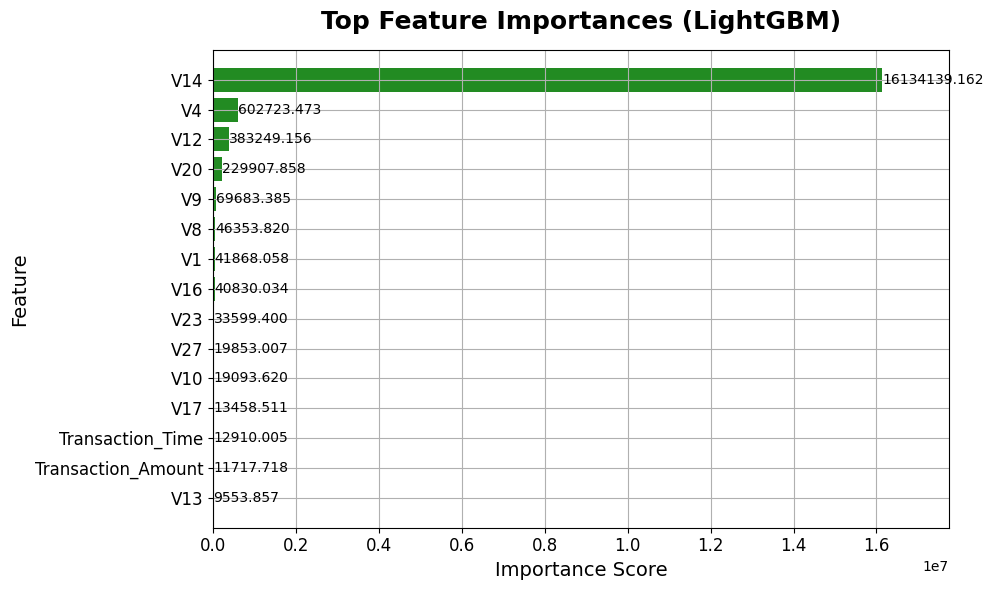

In [13]:
# Plot LightGBM feature importance with improved style and readability
fig, ax = plt.subplots(figsize=(10, 6))
lgb.plot_importance(
    model,
    ax=ax,
    height=0.8,
    title="Feature Importance (LightGBM)",
    color="forestgreen",
    importance_type='gain',  # 'gain' is often more informative than 'split'
    max_num_features=15,     # Show top 15 features for clarity
    xlabel="Importance Score"
)

# Add value labels to bars
ax.set_xlabel("Importance Score", fontsize=14)
ax.set_ylabel("Feature", fontsize=14)
ax.set_title("Top Feature Importances (LightGBM)", fontsize=18, fontweight='bold', pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

### Predict test data

In [14]:
predictions5 = model.predict(test_df[predictors])

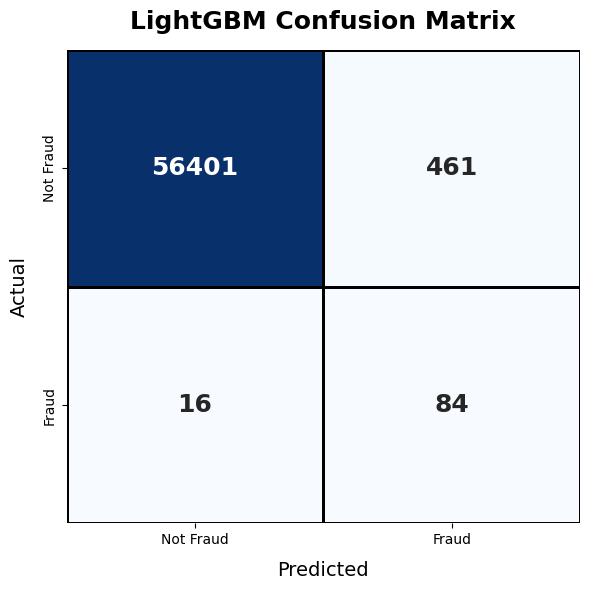

In [15]:
# Convert predicted probabilities to class labels (0 or 1) for LightGBM
test_pred_lgb = (predictions5 >= 0.5).astype(int)

# Create the confusion matrix
cm_lgb = confusion_matrix(test_df[target].values, test_pred_lgb)

# Plot the confusion matrix in the same style as XGBoost
plt.figure(figsize=(6, 6))
sns.heatmap(
    cm_lgb,
    annot=True,
    fmt='d',
    cmap="Blues",
    linewidths=1,
    linecolor="black",
    cbar=False,
    xticklabels=['Not Fraud', 'Fraud'],
    yticklabels=['Not Fraud', 'Fraud'],
    annot_kws={"size": 18, "weight": "bold"}
)

# Add title and labels
plt.title('LightGBM Confusion Matrix', fontsize=18, fontweight='bold', pad=15)
plt.xlabel('Predicted', fontsize=14, labelpad=10)
plt.ylabel('Actual', fontsize=14, labelpad=10)
plt.tight_layout()
plt.show()

### Success Metrics

- **Accuracy**: The proportion of total predictions that were correct.
- **Precision**: The proportion of positive identifications that were actually correct (minimizes false positives).
- **Recall (Sensitivity)**: The proportion of actual positives that were correctly identified (minimizes false negatives).
- **F1 Score**: The harmonic mean of precision and recall, providing a balance between the two.
- **ROC-AUC Score**: Measures the model's ability to distinguish between classes across all thresholds. A higher ROC-AUC indicates better overall classification performance, especially important for imbalanced datasets.
- **Classification Report**: A detailed summary including precision, recall, F1-score, and support for each class.

These metrics provide a more comprehensive view of model performance, especially for imbalanced datasets like fraud detection.

In [17]:
# Calculate and print evaluation metrics
def print_metrics(y_true, y_pred, dataset_name):
    print(f"--- {dataset_name} Metrics ---")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
    print(f"ROC-AUC Score: {roc_auc_score(y_true, y_pred):.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Not Fraud", "Fraud"]))
    print("\n")

# Get predictions for each set (convert probabilities to class labels)
train_pred_lgb = (model.predict(train_df[predictors]) >= 0.5).astype(int)
valid_pred_lgb = (model.predict(valid_df[predictors]) >= 0.5).astype(int)
test_pred_lgb = (predictions5 >= 0.5).astype(int)

# Print metrics
print_metrics(train_df[target].values, train_pred_lgb, "Train")
print_metrics(valid_df[target].values, valid_pred_lgb, "Validation")
print_metrics(test_df[target].values, test_pred_lgb, "Test")

--- Train Metrics ---
Accuracy: 0.9916
Precision: 0.1515
Recall: 0.9345
F1 Score: 0.2607
ROC-AUC Score: 0.9631

Classification Report:
               precision    recall  f1-score   support

   Not Fraud       1.00      0.99      1.00    181986
       Fraud       0.15      0.93      0.26       290

    accuracy                           0.99    182276
   macro avg       0.58      0.96      0.63    182276
weighted avg       1.00      0.99      0.99    182276



--- Validation Metrics ---
Accuracy: 0.9917
Precision: 0.1839
Recall: 0.7843
F1 Score: 0.2980
ROC-AUC Score: 0.8883

Classification Report:
               precision    recall  f1-score   support

   Not Fraud       1.00      0.99      1.00     45467
       Fraud       0.18      0.78      0.30       102

    accuracy                           0.99     45569
   macro avg       0.59      0.89      0.65     45569
weighted avg       1.00      0.99      0.99     45569



--- Test Metrics ---
Accuracy: 0.9916
Precision: 0.1541
Recall: 0

### Explanation of Evaluation Metrics

The following metrics are used to evaluate the performance of the LightGBM classifier on the fraud detection task:

- **Accuracy**: The proportion of total predictions that were correct. In imbalanced datasets, accuracy can be misleading, as a model can achieve high accuracy by simply predicting the majority class.

- **Precision**: The proportion of positive predictions (fraud) that were actually correct. High precision means that when the model predicts fraud, it is usually correct. Important when the cost of a false positive is high.

- **Recall (Sensitivity)**: The proportion of actual fraud cases that were correctly identified. High recall means the model detects most frauds. Important when missing a fraud case is costly.

- **F1 Score**: The harmonic mean of precision and recall. It balances the trade-off between precision and recall, especially useful for imbalanced datasets.

- **ROC-AUC Score**: Measures the model's ability to distinguish between classes across all thresholds. A higher ROC-AUC indicates better overall performance.

- **Classification Report**: Provides a detailed breakdown of precision, recall, F1-score, and support for each class (fraud and not fraud).

**Note:** In fraud detection, recall and ROC-AUC are often prioritized, as it is crucial to identify as many fraudulent transactions as possible, even if it means accepting some false positives.